In [ ]:
from typing import Mapping
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
import math
import fastcore.all as fc
from fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt

In [ ]:
from pathlib import Path
from IPython.display import Audio
import torchaudio.functional as taF
import torch.nn.functional as F
import torchaudio.transforms as T
from torch import tensor
from sounds.hits import data as D
from sounds.hits.data import *
from torch.utils.data import DataLoader, RandomSampler
import numpy as np

In [ ]:
sr = 16_000
xs = np.load('../data/train/dataset_x.npy')
ys = np.load('../data/train/dataset_y.npy')
valid_xs = np.load('../data/valid/dataset_x.npy')
valid_ys = np.load('../data/valid/dataset_y.npy')

https://pytorch.org/audio/main/generated/torchaudio.transforms.MFCC.html

In [ ]:
def augment_data(audio):
    if np.random.rand() < 0.5: 
        audio = T.Vol(gain=1.5)(audio)
    if np.random.rand() < 0.5: 
        audio = taF.add_noise(audio, torch.randn_like(audio)*0.5, snr = torch.randint(12, 30, ()))
    return audio

In [ ]:
from functools import partial

x_tfms = fc.Pipeline([tensor, T.Resample(new_freq=sr), T.MFCC(n_mfcc=60, melkwargs=dict(n_mels=128)), lambda x: 1+x/100])
y_tfms = [partial(tensor, dtype=torch.float32)]
train = D.TfmDataset(merge_items(xs, ys), x_tfms, y_tfms)
valid = D.TfmDataset(merge_items(valid_xs, valid_ys), x_tfms, y_tfms)

In [ ]:
dls = dataloaders(train, valid, batch_size=64, shuffle=True)

In [ ]:
xb,yb = next(iter(dls.train))

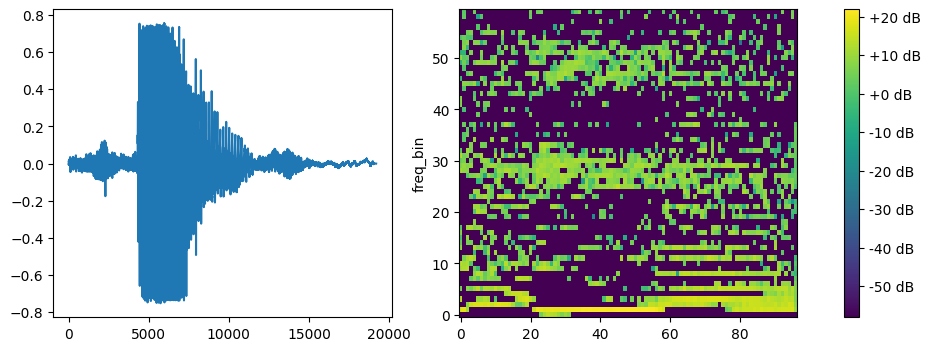

In [ ]:
describe(xs[1], spec_tfm=T.MFCC(n_mfcc=60, melkwargs=dict(n_mels=128)))

# Model

In [ ]:
def conv2d(n_in, n_out, k_size=3, stride=2, act=nn.ReLU(), p=None, norm=False):
    res = [nn.Conv2d(n_in, n_out, k_size, stride, padding=2, bias=False)]
    if p is not None: res.append(nn.Dropout(p))
    if norm: res.append(nn.GroupNorm(1,n_out))
    if act is not None: res.append(act)
    return nn.Sequential(*res)

In [ ]:
class AudioModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            conv2d(1, 16, p=0.3, k_size=5, norm=True),
            conv2d(16, 32, p=0.3, k_size=5, norm=True),
            conv2d(32, 64, p=0.3, k_size=3, norm=True),
            nn.Flatten(),
            nn.Linear(8064, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 1))
    
    def forward(self, x):
        return self.model(x[:,None]).squeeze(-1)

In [ ]:
from torcheval.metrics import BinaryAccuracy
from sounds.learner import *

In [ ]:
cbs = [DeviceCB(), MetricsCB(acc=BinaryAccuracy(threshold=torch.logit(tensor(0.7)))), ProgressCB()]
learn = Learner(dls, AudioModel(), F.binary_cross_entropy_with_logits, opt_func=optim.Adam, cbs=cbs)

In [ ]:
learn.fit(3, lr=1e-4)

acc,loss,epoch,train
0.692,0.445,0,train
0.987,0.026,0,eval
0.986,0.039,1,train
0.998,0.004,1,eval
0.995,0.014,2,train
0.997,0.004,2,eval


e:\Python\sounds\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [ ]:
torch.save(learn.model, '../models/spec.pth')

# Test

In [ ]:
import librosa
import numpy as np
from fastprogress import progress_bar

In [ ]:
model = torch.load('../models/spec.pth')

In [ ]:
path = Path('../data/thanos_message.wav')
sr = 16_000
max_length_s = 1.2 # seconds
max_l = int(max_length_s*sr)

In [ ]:
s, sr = librosa.load(path, sr=sr)

In [ ]:
test_frames = split_audio(s, max_l, stride=int(0.8*sr))

In [ ]:
i = iter(range(0, len(test_frames), 1))

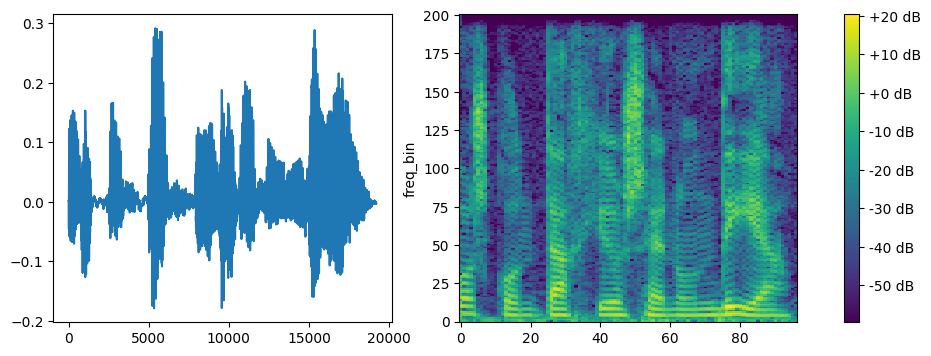

In [ ]:
idx = next(i)
describe(test_frames[1337])

In [ ]:
dl = DataLoader(D.TfmDataset(merge_items(test_frames, test_frames), x_tfms), batch_size=512)

In [ ]:
detected = []
for xb, yb in progress_bar(dl):
    with torch.no_grad():
        probs = F.sigmoid(model(to_device(xb))).cpu()
    detected += [(v,p.item()) for v,p in zip(yb,probs) if p>=0.49]

In [ ]:
detected = sorted(detected, key=lambda x: x[1], reverse=True)

In [ ]:
Audio(torch.cat(list(fc.L(detected).map(lambda x: x[0]))), rate=sr)

In [ ]:
# write detected to audio file
import torchaudio


torchaudio.save('../data/thanos_detected.wav', torch.cat(list(fc.L(detected).map(lambda x: x[0])), dim=0)[None], sr)